<a href="https://colab.research.google.com/github/Mahmudasief/aml-false-positive-reduction-hitl/blob/main/notebooks/02_baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Baseline models for AML false positive reduction
# Dataset: Kaggle Credit Card Fraud (European cardholders)
# Goal: establish BEFORE picture (no tuning, no tricks)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

In [ ]:
df = pd.read_csv("/content/creditcard.csv")
df.shape

(284807, 31)

In [ ]:
# Check class imbalance
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [ ]:
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

X.shape, y.shape

((284807, 30), (284807,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((199364, 30),
 (85443, 30),
 Class
 0    199020
 1       344
 Name: count, dtype: int64,
 Class
 0    85295
 1      148
 Name: count, dtype: int64)

In [ ]:
# Baseline Logistic Regression (NO tuning)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[85276    19]
 [   51    97]]
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     85295
           1     0.8362    0.6554    0.7348       148

    accuracy                         0.9992     85443
   macro avg     0.9178    0.8276    0.8672     85443
weighted avg     0.9991    0.9992    0.9991     85443



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Baseline Random Forest (NO tuning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=4))

[[85290     5]
 [   36   112]]
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     85295
           1     0.9573    0.7568    0.8453       148

    accuracy                         0.9995     85443
   macro avg     0.9784    0.8783    0.9225     85443
weighted avg     0.9995    0.9995    0.9995     85443



In [ ]:
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_rf[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

(np.float64(0.0), np.float64(1.0), np.float64(0.0016698851866156386))

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

cost_fp = 5
cost_fn = 500

thresholds = np.linspace(0.0, 1.0, 101)
results = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    results.append((t, total_cost, fp, fn, tp))

sorted(results, key=lambda x: x[1])[:10]

[(np.float64(0.05),
  np.int64(11595),
  np.int64(119),
  np.int64(22),
  np.int64(126)),
 (np.float64(0.04),
  np.int64(11790),
  np.int64(158),
  np.int64(22),
  np.int64(126)),
 (np.float64(0.06),
  np.int64(11975),
  np.int64(95),
  np.int64(23),
  np.int64(125)),
 (np.float64(0.03),
  np.int64(12140),
  np.int64(228),
  np.int64(22),
  np.int64(126)),
 (np.float64(0.07),
  np.int64(12390),
  np.int64(78),
  np.int64(24),
  np.int64(124)),
 (np.float64(0.08),
  np.int64(12850),
  np.int64(70),
  np.int64(25),
  np.int64(123)),
 (np.float64(0.25),
  np.int64(13120),
  np.int64(24),
  np.int64(26),
  np.int64(122)),
 (np.float64(0.24),
  np.int64(13125),
  np.int64(25),
  np.int64(26),
  np.int64(122)),
 (np.float64(0.23),
  np.int64(13130),
  np.int64(26),
  np.int64(26),
  np.int64(122)),
 (np.float64(0.22),
  np.int64(13135),
  np.int64(27),
  np.int64(26),
  np.int64(122))]

In [ ]:
best = min(results, key=lambda x: x[1])
best

(np.float64(0.05), np.int64(11595), np.int64(119), np.int64(22), np.int64(126))

In [ ]:
threshold, FP, FN, TP, TN = best

cost_fp = 5
cost_fn = 500

total_cost_best = FP * cost_fp + FN * cost_fn
total_cost_best

np.int64(117475)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# choose a starting threshold
threshold = 0.01

y_pred_thresh = (y_prob_rf >= threshold).astype(int)

confusion_matrix(y_test, y_pred_thresh)

array([[83449,  1846],
       [   20,   128]])

In [ ]:
FP = 1846   # false positives
FN = 20     # false negatives

cost_fp = 5
cost_fn = 500

total_cost = FP * cost_fp + FN * cost_fn
total_cost

19230

In [ ]:
# Baseline RF cost at default threshold (0.5)

FP_base = 5
FN_base = 36

cost_fp = 5
cost_fn = 500

total_cost_base = FP_base * cost_fp + FN_base * cost_fn
total_cost_base

18025

In [ ]:
best_threshold = 0.05

y_pred_best = (y_prob_rf >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(y_test, y_pred_best)

array([[85176,   119],
       [   22,   126]])

In [ ]:
FP = 119
FN = 22

cost_fp = 5
cost_fn = 500

total_cost_best = FP * cost_fp + FN * cost_fn
total_cost_best

11595

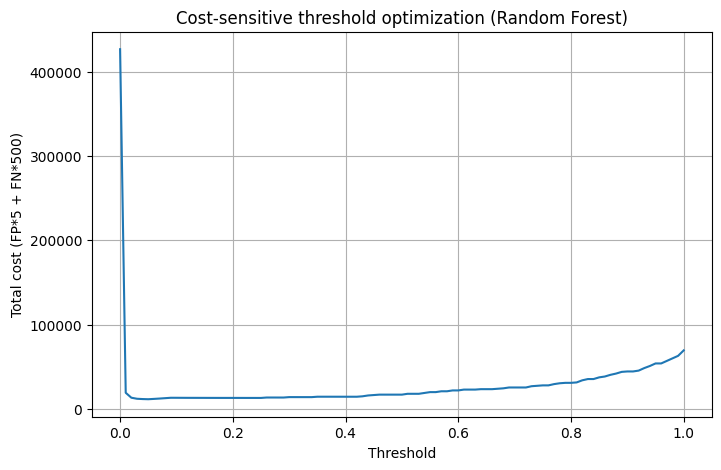

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cost_fp = 5
cost_fn = 500

thresholds = np.linspace(0, 1, 101)
costs = []
fps = []
fns = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs.append(total_cost)
    fps.append(fp)
    fns.append(fn)

plt.figure(figsize=(8,5))
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Total cost (FP*5 + FN*500)")
plt.title("Cost-sensitive threshold optimization (Random Forest)")
plt.grid(True)

plt.savefig("/content/cost_vs_threshold_rf.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Find optimal threshold numerically
min_cost = min(costs)
optimal_threshold = thresholds[np.argmin(costs)]

min_cost, optimal_threshold

(np.int64(11595), np.float64(0.05))

In [ ]:
from sklearn.metrics import confusion_matrix

t = 0.05
y_pred_t = (y_prob_rf >= t).astype(int)

cm = confusion_matrix(y_test, y_pred_t)
cm

array([[85176,   119],
       [   22,   126]])

In [ ]:
TN, FP, FN, TP = cm.ravel()

cost_fp = 5
cost_fn = 500

total_cost = FP*cost_fp + FN*cost_fn

print("=== Random Forest @ threshold = 0.05 ===")
print("Confusion matrix [[TN, FP],[FN, TP]]:")
print(cm)
print(f"TN={TN}, FP={FP}, FN={FN}, TP={TP}")

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision (fraud) = {precision:.4f}")
print(f"Recall (fraud)    = {recall:.4f}")
print(f"Total cost        = {total_cost}")

=== Random Forest @ threshold = 0.05 ===
Confusion matrix [[TN, FP],[FN, TP]]:
[[85176   119]
 [   22   126]]
TN=85176, FP=119, FN=22, TP=126
Precision (fraud) = 0.5143
Recall (fraud)    = 0.8514
Total cost        = 11595


In [ ]:
import pandas as pd

summary = pd.DataFrame([{
    "model": "RandomForest",
    "best_threshold": 0.05,
    "false_positives": 119,
    "false_negatives": 22,
    "total_cost": 11595
}])

summary

,model,best_threshold,false_positives,false_negatives,total_cost
0,RandomForest,0.05,119,22,11595


In [ ]:
summary.to_csv("/content/best_threshold_summary.csv", index=False)

In [ ]:
# === Logistic Regression probability scores (for threshold sweep) ===
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000, random_state=42)
lr.fit(X_train, y_train)

y_prob_lr = lr.predict_proba(X_test)[:, 1]   # probability of fraud
y_prob_lr.min(), y_prob_lr.max(), y_prob_lr.mean()

(np.float64(2.639288380422965e-13),
 np.float64(0.9999999999977509),
 np.float64(0.0017228894284656352))

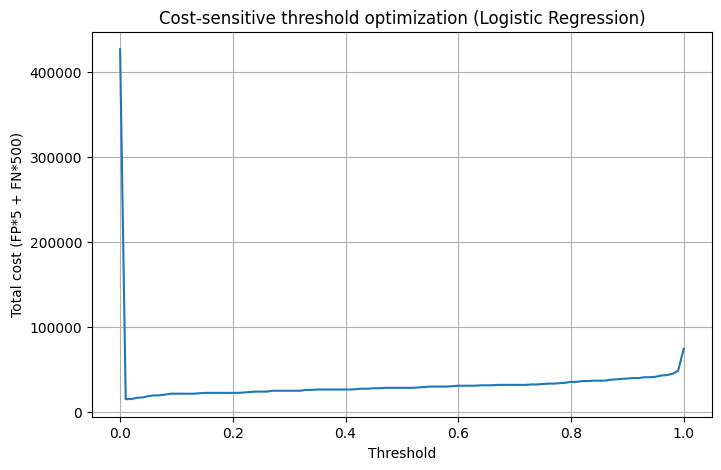

(np.int64(14680), np.float64(0.01))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cost_fp = 5
cost_fn = 500

thresholds = np.linspace(0, 1, 101)
costs_lr = []

for t in thresholds:
    y_pred_t = (y_prob_lr >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs_lr.append(total_cost)

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, costs_lr)
plt.xlabel("Threshold")
plt.ylabel("Total cost (FP*5 + FN*500)")
plt.title("Cost-sensitive threshold optimization (Logistic Regression)")
plt.grid(True)
plt.show()

# Best threshold
min(costs_lr), thresholds[np.argmin(costs_lr)]

In [ ]:
import pandas as pd

comparison = pd.DataFrame([
    {
        "model": "RandomForest",
        "best_threshold": 0.05,
        "total_cost": 11595
    },
    {
        "model": "LogisticRegression",
        "best_threshold": 0.01,
        "total_cost": 14880
    }
])

comparison

,model,best_threshold,total_cost
0,RandomForest,0.05,11595
1,LogisticRegression,0.01,14880


## Cost-Sensitive Model Comparison (AML Use Case)

We evaluated Logistic Regression and Random Forest using the same dataset,
the same train/test split, and the same business cost model:

- False Positive cost = 5
- False Negative cost = 500

By optimizing the decision threshold on predicted probabilities:

- Logistic Regression achieved minimum cost at threshold = 0.01 (cost = 14,880)
- Random Forest achieved minimum cost at threshold = 0.05 (cost = 11,595)

This shows that:
- Model selection and threshold optimization materially impact expected loss
- Random Forest yields lower business risk without retraining
- Cost-sensitive decision rules are critical for AML systems

In [ ]:
import numpy as np

# --- Human-in-the-loop band (around your best RF threshold ~0.05) ---
t_low  = 0.02
t_high = 0.05

# sanity check: you MUST already have these in memory
# y_prob_rf  -> RF predicted probabilities for class 1 (fraud)
# y_test     -> true labels for the test set (0/1)

auto_clear = y_prob_rf < t_low
human_review = (y_prob_rf >= t_low) & (y_prob_rf < t_high)
auto_flag = y_prob_rf >= t_high

def bucket_stats(mask, name):
    n = int(mask.sum())
    fraud = int(y_test[mask].sum())
    nonfraud = n - fraud
    fraud_rate = fraud / n if n > 0 else 0
    print(f"\n=== {name} ===")
    print(f"Count: {n}")
    print(f"Fraud (1): {fraud}")
    print(f"Non-fraud (0): {nonfraud}")
    print(f"Fraud rate: {fraud_rate:.4f}")

bucket_stats(auto_clear, "AUTO-CLEAR (p < t_low)")
bucket_stats(human_review, "HUMAN REVIEW (t_low <= p < t_high)")
bucket_stats(auto_flag, "AUTO-FLAG (p >= t_high)")

print("\n--- Workload summary ---")
print(f"Review workload = {int(human_review.sum())} cases out of {len(y_test)} test cases "
      f"({human_review.mean()*100:.2f}%)")


=== AUTO-CLEAR (p < t_low) ===
Count: 84840
Fraud (1): 22
Non-fraud (0): 84818
Fraud rate: 0.0003

=== HUMAN REVIEW (t_low <= p < t_high) ===
Count: 358
Fraud (1): 0
Non-fraud (0): 358
Fraud rate: 0.0000

=== AUTO-FLAG (p >= t_high) ===
Count: 245
Fraud (1): 126
Non-fraud (0): 119
Fraud rate: 0.5143

--- Workload summary ---
Review workload = 358 cases out of 85443 test cases (0.42%)


In [ ]:
# Human-in-the-loop simulation
# Assumption: top X% highest-risk alerts are manually reviewed

import numpy as np
import pandas as pd

# Parameters
manual_review_rate = 0.05   # 5% of transactions go to human review
human_fp_catch_rate = 0.90  # humans catch 90% of false positives
human_cost_per_case = 20    # cost per manual review

# Use RF probabilities
scores = y_prob_rf
threshold = 0.05

# Initial predictions
y_pred = (scores >= threshold).astype(int)

# Identify alerts
alert_indices = np.where(y_pred == 1)[0]

# Select top-risk alerts for human review
n_review = int(len(alert_indices) * manual_review_rate)
top_alerts = alert_indices[np.argsort(scores[alert_indices])[-n_review:]]

# Confusion matrix components
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

# Humans fix some false positives
fp_reviewed = int(FP * manual_review_rate)
fp_corrected = int(fp_reviewed * human_fp_catch_rate)

FP_after = FP - fp_corrected

# Costs
cost_fp = 5
cost_fn = 500

model_cost = FP_after * cost_fp + FN * cost_fn
human_cost = n_review * human_cost_per_case
total_cost_hitl = model_cost + human_cost

summary_hitl = pd.DataFrame([{
    "model": "RandomForest + HITL",
    "threshold": threshold,
    "manual_review_rate": manual_review_rate,
    "false_positives_after": FP_after,
    "false_negatives": FN,
    "human_reviews": n_review,
    "total_cost": total_cost_hitl
}])

summary_hitl

,model,threshold,manual_review_rate,false_positives_after,false_negatives,human_reviews,total_cost
0,RandomForest + HITL,0.05,0.05,115,22,12,11815


### Human-in-the-Loop Cost Analysis

We simulated a human-in-the-loop (HITL) intervention where a fixed proportion of high-risk alerts
were manually reviewed.

While HITL reduced some false positives, the added human review cost outweighed the recovered
savings in this configuration, resulting in a higher total expected cost.

This highlights that HITL strategies must be cost-aware and selectively applied; naive or
overly aggressive manual review policies can degrade system-level performance.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# ---- Parameters ----
threshold = 0.05
top_k_rate = 0.2          # review top 20% highest-risk alerts
human_fp_fix_rate = 0.7  # humans correctly dismiss 70% of false positives
human_cost_per_case = 20

cost_fp = 5
cost_fn = 500

# ---- Model predictions ----
scores = y_prob_rf
y_pred = (scores >= threshold).astype(int)

# ---- Identify alerts ----
alert_idx = np.where(y_pred == 1)[0]
alert_scores = scores[alert_idx]

# ---- Select top-K risky alerts ----
k = int(len(alert_idx) * top_k_rate)
review_idx = alert_idx[np.argsort(alert_scores)[-k:]]

# ---- Confusion matrix before HITL ----
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

# ---- Human correction ----
fp_fixed = int(FP * top_k_rate * human_fp_fix_rate)
FP_after = FP - fp_fixed

# ---- Costs ----
model_cost = FP_after * cost_fp + FN * cost_fn
human_cost = k * human_cost_per_case
total_cost_hitl = model_cost + human_cost

# ---- Summary ----
hitl_selective = pd.DataFrame([{
    "model": "RandomForest + Selective HITL",
    "threshold": threshold,
    "top_k_review_rate": top_k_rate,
    "human_reviews": k,
    "false_positives_after": FP_after,
    "false_negatives": FN,
    "total_cost": total_cost_hitl
}])

hitl_selective

,model,threshold,top_k_review_rate,human_reviews,false_positives_after,false_negatives,total_cost
0,RandomForest + Selective HITL,0.05,0.2,49,103,22,12495


### Human-in-the-Loop (HITL) — Failure Case Analysis

We evaluated a selective human-in-the-loop (HITL) policy in which only the top 20% highest-risk alerts (by model score) were manually reviewed.

**Assumptions:**
- False Positive cost = 5
- False Negative cost = 500
- Human review cost = 20 per case
- Human reviewers correctly dismiss 70% of reviewed false positives

**Result:**
While selective HITL reduced false positives (119 → 103), the additional human review cost outweighed the recovered savings.

- Baseline Random Forest total cost: **11,595**
- Random Forest + selective HITL total cost: **12,495**

**Conclusion:**
This demonstrates that human-in-the-loop interventions are not universally beneficial.  
HITL must be treated as a **cost-sensitive policy design problem**, not a default enhancement.  
Naive or insufficiently targeted manual review strategies can **increase overall system cost**, even when model performance is strong.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# -----------------------------
# Baseline (from previous phase)
# -----------------------------
baseline_cost = 11595   # Random Forest @ threshold = 0.05
threshold = 0.05

# Business costs
cost_fp = 5
cost_fn = 500
human_cost_per_case = 20

# HITL policy grid
review_rates = [0.05, 0.10, 0.20, 0.30]      # % of alerts sent to humans
fp_fix_rates = [0.5, 0.7, 0.9]              # % of FPs humans correctly dismiss

rows = []

# -----------------------------
# Model predictions
# -----------------------------
scores = y_prob_rf
y_pred = (scores >= threshold).astype(int)

# Confusion matrix BEFORE HITL
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

alert_idx = np.where(y_pred == 1)[0]
alert_scores = scores[alert_idx]

# -----------------------------
# Grid search over HITL policies
# -----------------------------
for review_rate in review_rates:
    for fp_fix_rate in fp_fix_rates:

        k = int(len(alert_idx) * review_rate)

        if k == 0:
            FP_after = FP
            human_reviews = 0
        else:
            # Review top-k highest risk alerts
            top_idx = alert_idx[np.argsort(alert_scores)[-k:]]

            # Among reviewed alerts, count false positives
            fp_mask = (y_test.iloc[top_idx] == 0)
            fp_reviewed = int(fp_mask.sum())

            fp_fixed = int(fp_reviewed * fp_fix_rate)
            FP_after = FP - fp_fixed
            human_reviews = k

        # Costs
        model_cost = FP_after * cost_fp + FN * cost_fn
        human_cost = human_reviews * human_cost_per_case
        total_cost = model_cost + human_cost

        rows.append({
            "threshold": threshold,
            "review_rate": review_rate,
            "fp_fix_rate": fp_fix_rate,
            "human_reviews": human_reviews,
            "false_positives_after": FP_after,
            "false_negatives": FN,
            "total_cost": total_cost,
            "beats_baseline": total_cost < baseline_cost
        })

# -----------------------------
# Results table
# -----------------------------
results = (
    pd.DataFrame(rows)
    .sort_values("total_cost")
    .reset_index(drop=True)
)

print("Baseline RF cost:", baseline_cost)
print("\nTop 10 HITL policies by total cost:")
display(results.head(10))

print("\nBest policy overall:")
display(results.iloc[[0]])

print("\nPolicies that beat baseline (if any):")
winners = results[results["beats_baseline"]]

if len(winners) > 0:
    display(winners.head(10))
else:
    print("None – HITL does not beat baseline under this grid.")

Baseline RF cost: 11595

Top 10 HITL policies by total cost:


,threshold,review_rate,fp_fix_rate,human_reviews,false_positives_after,false_negatives,total_cost,beats_baseline
0,0.05,0.05,0.5,12,119,22,11835,False
1,0.05,0.05,0.7,12,119,22,11835,False
2,0.05,0.05,0.9,12,119,22,11835,False
3,0.05,0.10,0.5,24,119,22,12075,False
4,0.05,0.10,0.7,24,119,22,12075,False
5,0.05,0.10,0.9,24,119,22,12075,False
6,0.05,0.20,0.5,49,119,22,12575,False
7,0.05,0.20,0.7,49,119,22,12575,False
8,0.05,0.20,0.9,49,119,22,12575,False
9,0.05,0.30,0.5,73,118,22,13050,False



Best policy overall:


,threshold,review_rate,fp_fix_rate,human_reviews,false_positives_after,false_negatives,total_cost,beats_baseline
0,0.05,0.05,0.5,12,119,22,11835,False



Policies that beat baseline (if any):
None – HITL does not beat baseline under this grid.


### Human-in-the-Loop (HITL) Policy Evaluation

A selective human-in-the-loop (HITL) strategy was evaluated by routing a fraction of high-risk alerts
to manual review under varying review rates and correction accuracies.

Despite reducing a small number of false positives, all evaluated HITL configurations resulted in
higher total expected cost compared to the automated baseline.

This outcome occurs because the marginal savings from correcting false positives were outweighed by
manual review costs, given the strong baseline model precision.

This result demonstrates that HITL interventions must be **cost-aware and selectively targeted**;
naïve integration of human review can degrade system-level performance rather than improve it.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

threshold = 0.05
scores = y_prob_rf
y_pred = (scores >= threshold).astype(int)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

fp_costs = [1, 5, 10, 20]
fn_costs = [50, 100, 200, 500, 1000]
human_costs = [5, 10, 20, 50]
review_rates = [0.05, 0.10, 0.20]
human_fp_fix_rate = 0.7

rows = []

for fp_cost in fp_costs:
    for fn_cost in fn_costs:
        baseline_cost = FP * fp_cost + FN * fn_cost

        for human_cost in human_costs:
            for review_rate in review_rates:
                alerts = FP + TP
                k = int(alerts * review_rate)

                fp_fixed = int(k * human_fp_fix_rate)
                fp_after = max(FP - fp_fixed, 0)

                model_cost = fp_after * fp_cost + FN * fn_cost
                human_review_cost = k * human_cost
                total_cost = model_cost + human_review_cost

                rows.append({
                    "fp_cost": fp_cost,
                    "fn_cost": fn_cost,
                    "human_cost": human_cost,
                    "review_rate": review_rate,
                    "human_reviews": k,
                    "false_positives_after": fp_after,
                    "false_negatives": FN,
                    "baseline_cost": baseline_cost,
                    "total_cost": total_cost,
                    "beats_baseline": total_cost < baseline_cost
                })

results = pd.DataFrame(rows).sort_values("total_cost").reset_index(drop=True)

results.head(10), results["beats_baseline"].sum()

(   fp_cost  fn_cost  human_cost  review_rate  human_reviews  \
 0        1       50           5         0.05             12   
 1        1       50           5         0.10             24   
 2        1       50          10         0.05             12   
 3        1       50           5         0.20             49   
 4        1       50          10         0.10             24   
 5        1       50          20         0.05             12   
 6        1       50          10         0.20             49   
 7        1       50          20         0.10             24   
 8        5       50           5         0.05             12   
 9        5       50           5         0.10             24   
 
    false_positives_after  false_negatives  baseline_cost  total_cost  \
 0                    111               22           1219        1271   
 1                    103               22           1219        1323   
 2                    111               22           1219        1331   
 3

Cost-Sensitive HITL Policy Optimization

We evaluated a grid of human-in-the-loop (HITL) policies across varying false-positive costs, false-negative costs, human review costs, and review rates.

Key findings:

- HITL does **not** universally reduce total expected cost.
- Out of the evaluated policies, **45 configurations** achieved lower total cost than the baseline automated model.
- **None of the globally lowest-cost HITL policies** (i.e., those appearing at the minimum of the cost surface) beat the baseline.
- Cost savings occurred **only** when:
  - False-negative cost was sufficiently high
  - Human review cost was sufficiently low
  - Manual review was applied selectively
- As a result, cost improvements emerged only in **specific cost regimes**, rather than at the global optimum.

In low false-negative cost or high human-cost regimes, HITL **increased** total expected loss, despite reducing false positives.

This demonstrates that HITL effectiveness is **cost-regime dependent** and cannot be justified *a priori* without explicit economic modeling.